# Roman Observatory Visualization for Targets (Keep Out Map)

In [2]:
from roman_pointing import calcRomanAngles, getL2Positions, getSunPositions
import astropy.units as u
from astropy.time import Time
from astroquery.simbad import Simbad
from astroquery.jplhorizons import Horizons
from astropy.coordinates import (
    SkyCoord,
    Distance,
    get_body_barycentric,
    BarycentricMeanEcliptic,
)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Query SIMBAD and convert to BarycentricMeanEcliptic coords
def get_target_coords(target_names):
    simbad = Simbad()
    simbad.add_votable_fields("pmra", "pmdec", "plx_value", "rvz_radvel")

    coords = {}

    for name in target_names:
        res = simbad.query_object(name)
        if res is None:
            print(f" SIMBAD could not find {name}")
            continue

        c_icrs = SkyCoord(
            res["ra"].value.data[0],
            res["dec"].value.data[0],
            unit=(res["ra"].unit, res["dec"].unit),
            frame="icrs",
            distance=Distance(parallax=res["plx_value"].value.data[0] * res["plx_value"].unit),
            pm_ra_cosdec=res["pmra"].value.data[0] * res["pmra"].unit,
            pm_dec=res["pmdec"].value.data[0] * res["pmdec"].unit,
            radial_velocity=res["rvz_radvel"].value.data[0] * res["rvz_radvel"].unit,
            equinox="J2000",
            obstime="J2000"
        ).transform_to(BarycentricMeanEcliptic)

        coords[name] = c_icrs
    
    return coords

# Compute Roman pointing angles
def compute_roman_angles(coord, start_date, days, time_step):    
    t0 = Time(start_date, format="isot", scale="utc")
    ts = t0 + np.arange(0, days, time_step) * u.d

    sun_ang, yaw, pitch, BCI = calcRomanAngles(
        coord,
        ts,
        getL2Positions(ts)
    )
    
    return ts, sun_ang, yaw, pitch


# Compute multi-target keepout
def compute_keepout(coords_dict, start_date, days, time_step, min_sun=54, max_sun=126):
    solar_angles = {}
    keepout = {}
    ts_global = None

    for name, coord in coords_dict.items():
        ts, sun_ang, yaw, pitch = compute_roman_angles(
            coord, start_date, days, time_step
        )

        solar_angles[name] = sun_ang
        keepout[name] = (sun_ang > min_sun*u.deg) & (sun_ang < max_sun*u.deg)

        if ts_global is None:
            ts_global = ts
    
    return ts_global, keepout, solar_angles

# Plot solar angles
def plot_solar_angle(ts, solar_angles_dict):
    """
    solar_angles_dict : {name: sun_angle_array}
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    for name, sun in solar_angles_dict.items():
        ax.plot(range(len(ts)), sun.to(u.deg), label=name)

    ax.set_xlabel(f"Time after {ts[0].value} (days)")
    ax.set_ylabel("Solar Angle (deg)")

    # solar keepout boundaries
    ax.plot([0, len(ts)], [54, 54], "k--")
    ax.plot([0, len(ts)], [126, 126], "k--")

    ax.fill_between([0, len(ts)], [54, 54], [0, 0], hatch="/", color="none", edgecolor="k")
    ax.fill_between([0, len(ts)], [126, 126], [180, 180], hatch="\\", color="none", edgecolor="k")

    ax.set_title("Solar Angle vs Time")
    ax.legend()

    return fig, ax
# Plot pitch angles    
def plot_pitch(ts, pitch_dict):
    fig, ax = plt.subplots(figsize=(10, 5))

    for name, pitch in pitch_dict.items():
        ax.plot(range(len(ts)), pitch.to(u.deg), label=name)

    ax.set_xlabel(f"Time after {ts[0].value} (days)")
    ax.set_ylabel("Pitch Angle (deg)")
    ax.set_title("Pitch Angle vs Time")
    ax.legend()

    return fig, ax


# Plot keepout map 
def plot_keepout(keepout_dict, ts):
    names = list(keepout_dict.keys())
    M = len(names)

    komap = np.vstack([keepout_dict[n] for n in names])

    fig, ax = plt.subplots(figsize=(12, 1.3*M + 3))
    cmap = matplotlib.colors.ListedColormap(["black", "green"])

    p = ax.pcolor(np.arange(komap.shape[1]), np.arange(M), komap, cmap=cmap)

    ax.set_yticks(np.arange(M))
    ax.set_yticklabels(names)
    ax.set_xlabel("Time Index")

    cbar = plt.colorbar(p, ticks=[0.25, 0.75], drawedges=True)
    cbar.ax.set_yticklabels(["Unavailable", "Available"])

    ax.set_title(f"Roman Keepout Map\n{ts[0].iso} → {ts[-1].iso}")

    return fig, ax


## Keep Out Map 

Enter targets separated by commas:
 47 Uma, HD 189733, TRAPPIST-1
Start date (YYYY-MM-DD):  2027-01-01
Number of days:  365
Time step (days):  1


(<Figure size 1200x690 with 2 Axes>,
 <Axes: title={'center': 'Roman Keepout Map\n2027-01-01 00:00:00.000 → 2027-12-31 00:00:00.000'}, xlabel='Time Index'>)

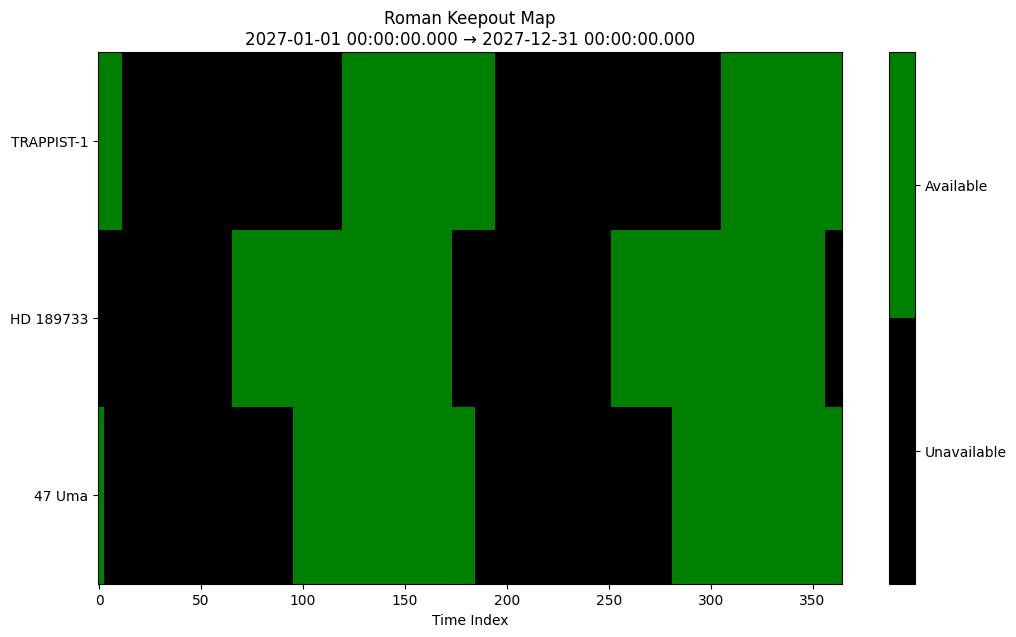

In [3]:
targets = input("Enter targets separated by commas:\n").split(",")
targets = [t.strip() for t in targets]

start_date = input("Observation Start Date (YYYY-MM-DD): ")
days = float(input("Total number of days for the observation period: "))
step = float(input("Time step (days): "))

coords = get_target_coords(targets)

ts, keepout, solar = compute_keepout(coords, start_date, days, step)

plot_keepout(keepout, ts)

## Solar and Pitch Plot

Enter targets separated by commas:
 47 Uma, HD 189733, TRAPPIST-1
Start date (YYYY-MM-DD):  2027-01-01
Number of days:  365
Time step (days):  1


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Pitch Angle vs Time'}, xlabel='Time after 2027-01-01T00:00:00.000 (days)', ylabel='Pitch Angle (deg)'>)

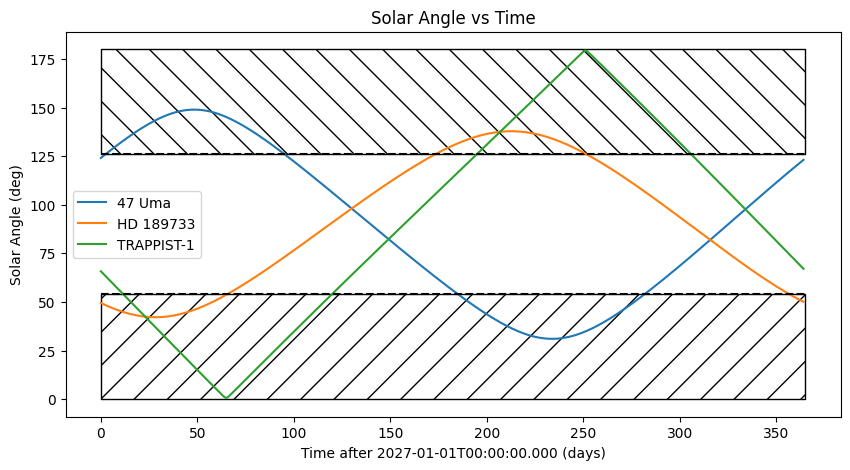

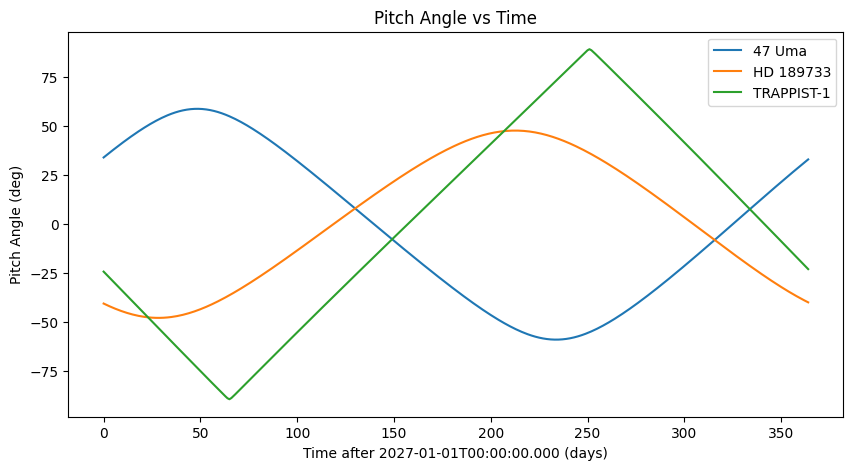

In [4]:
# Example with the plot for solar, pitch
targets = input("Enter targets separated by commas:\n").split(",")
targets = [t.strip() for t in targets]

start_date = input("Observation Start Date (YYYY-MM-DD): ")
days = float(input("Total number of days for the observation period "))
step = float(input("Time step (days): "))

coords = get_target_coords(targets)


# Compute angles for each target
sun_dict = {}
pitch_dict = {}
for t, c in coords.items():
    ts, sun, yaw, pitch = compute_roman_angles(c, "2027-01-01", 365, 1)
    sun_dict[t] = sun
    pitch_dict[t] = pitch

plot_solar_angle(ts, sun_dict)
plot_pitch(ts, pitch_dict)

